In [1]:
import pandas as pd
import numpy as np
import re
import os
from statsmodels.formula.api import ols

pd.set_option('display.max_colwidth', None)

In [2]:
pbp = pd.DataFrame()
for season in range(2004, 2021):
    df = pd.read_csv(f'cfb_pbp_raw/cfb_pbp_raw_{season}.csv')
    df['season'] = season
    pbp = pd.concat([pbp, df])

In [3]:
pbp.play_type.value_counts()

Rush                                  870950
Pass Incompletion                     282308
Pass Completion                       235057
Pass Reception                        185085
Kickoff                               122315
Punt                                  118308
Penalty                               112867
Timeout                                75409
Extra Point Good                       43038
Sack                                   42304
Pass                                   39754
Field Goal Good                        27548
Rushing Touchdown                      19120
Passing Touchdown                      17942
End Period                             14319
Pass Interception                      12227
Field Goal Missed                       9426
Pass Interception Return                8380
Kickoff Return (Offense)                6333
Fumble Recovery (Own)                   6053
End of Half                             5499
Fumble Recovery (Opponent)              5299
Punt Retur

In [4]:
pbp = pbp.replace(
    {
        'Pass Reception':'Pass Completion',
        'Pass Interception Return':'Interception',
        'Pass Interception':'Interception',
        'Interception Return Touchdown':'Interception',
    }
)

In [5]:
pbp.play_type.value_counts()

Rush                                  870950
Pass Completion                       420142
Pass Incompletion                     282308
Kickoff                               122315
Punt                                  118308
Penalty                               112867
Timeout                                75409
Extra Point Good                       43038
Sack                                   42304
Pass                                   39754
Field Goal Good                        27548
Interception                           21685
Rushing Touchdown                      19120
Passing Touchdown                      17942
End Period                             14319
Field Goal Missed                       9426
Kickoff Return (Offense)                6333
Fumble Recovery (Own)                   6053
End of Half                             5499
Fumble Recovery (Opponent)              5299
Punt Return                             4754
End of Game                             3901
Extra Poin

In [6]:
pass_cols = ['Pass Completion', 
             'Pass Incompletion', 
             'Sack',
             'Pass',
             'Interception',
             'Passing Touchdown',
            ]
rush_cols = ['Rush', 'Rushing Touchdown']

pbp['pass'] = np.where(pbp['play_type'].isin(pass_cols), 1, 0)
pbp['rush'] = np.where(pbp['play_type'].isin(rush_cols), 1, 0)

In [7]:
passes = pbp.loc[pbp['pass']==1]

In [17]:
def sample_fn(s):
    return s.sample(1)

def extract_passer(s):
    ptype = s[0]
    ptext = s[1].split('penalty')[0].split('Penalty')[0].split('PENALTY')[0].replace(' for a TD', '')
    if ptype in ['Pass Completion', 'Pass Incompletion', 'Sack', 'Pass', 'Interception', 'Passing Touchdown']:
        if ptype=="Pass" and " fumble" in ptext:
            return "NA"            
        try:
            if ptype=="Passing Touchdown" and " pass from " in ptext:
                name = re.search(r"\d+(.*)pass from (.*) \(", ptext).group(2)
            elif ptype == 'Sack' or (ptype=='Pass' and ' sacked ' in ptext):
                name = re.search(r"(.*) sacked ", ptext).group(1)
            else:
                name = re.search(r"(.*) pass ", ptext).group(1)
            if "(" in name:
                name = name.split(" (")[0]
            last_token = name.split()[-1]
            if last_token == 'Yd':
                name = ' '.join(name.split()[:-2])
            if last_token in ['sideline', 'middle']:
                name = ' '.join(name.split()[:-1])
            return name
        except Exception as e:
            return "NA"
    return "NA"

def extract_receiver(s):
    ptype = s[0]
    ptext = s[1].replace(' a loss of ', ' ')\
                .replace(' no gain ', ' 0 ')\
                .replace(' right side ', ' ')\
                .replace(' left side ', ' ')\
                .replace(' across the middle ', ' ')
    if ptype == 'Pass Completion' or ptype=='Passing Touchdown' or (ptype=='Pass' and ' pass complete to ' in ptext):
        try:
            if ptype=="Passing Touchdown" and " pass from " in ptext:
                name = re.search(r"(.*) \d+ Yd", ptext).group(1)
            else:
                name = re.search(r"pass(.*)complete to (.*) for \d+", ptext).group(2)

            if "(" in name:
                name = name.split(" (")[0]
            return name
        except Exception as e:
            return "ERROR"
    return "NA"

sample = passes.groupby('play_type', as_index=False).agg({'play_text':sample_fn})
sample['play_type_and_text'] = list(zip(sample['play_type'], sample['play_text']))
sample['passer'] = sample['play_type_and_text'].apply(extract_passer)
sample['receiver'] = sample['play_type_and_text'].apply(extract_receiver)
sample.drop(columns=['play_type_and_text'])

,play_type,play_text,passer,receiver
0,Interception,"Brandon Connette pass intercepted by Jayron Hosley at the Duke 41, returned for 17 yards to the Duke 24.",Brandon Connette,NA
1,Pass,Jordan Palmer pass complete to Chris Francies for 11 yards to the Tulsa 19 for a 1ST down.,Jordan Palmer,Chris Francies
2,Pass Completion,Philip Nelson pass complete to Zay Jones for 12 yds to the ECaro 34 for a 1ST down,Philip Nelson,Zay Jones
3,Pass Incompletion,Tanner Price crossing pass incomplete to Sherman Ragland III.,Tanner Price crossing,NA
4,Passing Touchdown,"Garrett Smith pass complete to Harley Scioneaux for 17 yds for a TD, (Craig Ford KICK)",Garrett Smith,Harley Scioneaux
5,Sack,Jalen Whitlow sacked by Daniel McCullers for a loss of 1 yard to the Tenn 34.,Jalen Whitlow,NA


In [18]:
pbp['play_type_and_text'] = list(zip(pbp['play_type'].astype('str'), pbp['play_text'].astype('str')))
pbp['passer'] = pbp['play_type_and_text'].apply(extract_passer)
pbp['receiver'] = pbp['play_type_and_text'].apply(extract_receiver)

In [ ]:
if not os.path.exists('cfb_pbp'):
    os.makedirs('cfb_pbp')

for season in pbp.season.unique():
    pbp.loc[pbp.season==season].to_csv(f'cfb_pbp/cfb_pbp_{season}.csv')

In [23]:
ranking_df = pd.read_csv('cfb_rankings_04_20.csv')

In [24]:
# Over expectation is determined based on the player and opponent's:
# - Ranking - Ranked/Non-Ranked
# - Power 5 conference - Yes/No
# - Era - 2004-2009, 2010-2015, 2016-2020
p5 = ['Pac-10', 'Pac-12', 'Big Ten', 'Big 12', 'ACC', 'SEC']

pbp['off_p5'] = np.where(pbp['offense_conference'].isin(p5), 1, 0)
pbp['def_p5'] = np.where(pbp['offense_conference'].isin(p5), 1, 0)

In [25]:
pbp = pbp.merge(
    ranking_df[['year', 'school', 'rank']].rename(columns={'rank':'offense_rank'}), 
    left_on=['season', 'offense'],
    right_on=['year', 'school'],
    how='left').drop(columns=['year', 'school'])
pbp = pbp.merge(
    ranking_df[['year', 'school', 'rank']].rename(columns={'rank':'defense_rank'}), 
    left_on=['season', 'defense'],
    right_on=['year', 'school'],
    how='left').drop(columns=['year', 'school'])

In [26]:
pbp['off_ranked'] = np.where(pbp['offense_rank'].isna(), 0, 1)
pbp['def_ranked'] = np.where(pbp['defense_rank'].isna(), 0, 1)

era_map = {}
for year in range(2004, 2021):
    if year < 2010:
        era_map[year] = '2004-2009'
    elif year < 2016:
        era_map[year] = '2010-2015'
    else:
        era_map[year] = '2016-2020'
    
pbp['era'] = pbp['season'].apply(lambda x: era_map[x])

In [28]:
model = ols('ppa ~ C(off_p5) + C(def_p5) + C(off_ranked) + C(def_ranked) + C(era)', data=pbp)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppa   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1317.
Date:                Fri, 19 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:40:41   Log-Likelihood:            -2.6689e+06
No. Observations:             1665952   AIC:                         5.338e+06
Df Residuals:                 1665946   BIC:                         5.338e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0061      0.002      3.042      0.002       0.002       0.010
C(off_p5)[T.1]          0.0100      0.001     10.055      0.000       0.008       0.012
C(def_p5)[T.1]          0.0100      0.001     10.055      0.000       0.008       0.012
C(off_ranked)[T.1]      0.0843      0.002     34.744      0.000       0.080       0.089
C(def_ranked)[T.1]     -0.0877      0.002    -36.982      0.000      -0.092      -0.083
C(era)[T.2010-2015]     0.0645      0.002     28.316      0.000       0.060       0.069
C(era)[T.2016-2020]     0.1446      0.002     60.842      0.000       0.140       0.149
==============================================================================
Omnibus:                   238710.410   Durbin-Watson:                   2.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1607178.062
Skew:                           0.513   Prob(JB):                         0.00
Kurtosis:                       7.701   Cond. No.                     4.46e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.67e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [30]:
pbp['ppaoe'] = fitted_model.resid

In [33]:
filtered = pbp.loc[(pbp.passer!="NA") & (pbp.offense_conference.isin(p5))].copy()
best_qb_seasons = filtered.groupby(['season','passer'], as_index=False).agg({'ppaoe':['sum', 'mean'], 'yards_gained':['sum', 'mean'], 'id':'count'})
best_qb_seasons.columns = ['season', 'receiver', 'ppa_sum', 'ppa_mean', 'yards', 'ypp', 'play_count']
best_qb_seasons.sort_values('ppa_sum', ascending=False)[:10]

,season,receiver,ppa_sum,ppa_mean,yards,ypp,play_count
4342,2018,Kyler Murray,183.934629,0.539398,3810.0,10.823864,352
4606,2019,Joe Burrow,177.141872,0.392776,4449.0,9.650759,461
3646,2016,Baker Mayfield,175.340379,0.521846,3437.0,10.108824,340
3919,2017,Baker Mayfield,168.205565,0.444988,4119.0,10.726562,384
3838,2016,Patrick Mahomes II,165.968236,0.275238,4748.0,7.732899,614
3265,2014,Marcus Mariota,157.474157,0.398669,3664.0,9.206030,398
3478,2015,Jared Goff,153.798015,0.305761,3914.0,7.659491,511
3384,2015,Brandon Allen,147.786534,0.437238,2908.0,8.284900,351
3222,2014,Jared Goff,146.763969,0.283328,3743.0,7.075614,529
4406,2018,Ryan Finley,146.251868,0.325728,3636.0,8.008811,454


In [40]:
filtered = pbp.loc[(pbp.passer!="NA") & (pbp.offense_conference.isin(p5))].copy()
best_qb_seasons = filtered.groupby(['season','passer'], as_index=False).agg({'ppaoe':['sum', 'mean'], 'yards_gained':['sum', 'mean'], 'id':'count'})
best_qb_seasons.columns = [ 'season', 'receiver', 'ppa_sum', 'ppa_mean', 'yards', 'ypp', 'play_count']
best_qb_seasons.loc[best_qb_seasons.play_count>100].sort_values('ppa_mean', ascending=False)[:10]

,season,receiver,ppa_sum,ppa_mean,yards,ypp,play_count
3480,2015,Jarrett Stidham,65.050875,0.551279,1199.0,10.161017,118
4342,2018,Kyler Murray,183.934629,0.539398,3810.0,10.823864,352
3646,2016,Baker Mayfield,175.340379,0.521846,3437.0,10.108824,340
3188,2014,Deshaun Watson,74.199197,0.518876,1433.0,9.882759,145
4452,2018,Tua Tagovailoa,136.957204,0.462693,3175.0,10.548173,301
4738,2019,Tua Tagovailoa,114.373589,0.448524,2653.0,10.125954,262
3919,2017,Baker Mayfield,168.205565,0.444988,4119.0,10.726562,384
4588,2019,Jalen Hurts,143.716475,0.443569,3169.0,9.632219,329
4899,2020,Mac Jones,144.635132,0.442309,3724.0,11.083333,336
3587,2015,Seth Russell,85.854684,0.438034,1996.0,9.881188,202


In [ ]:
filtered = pbp.loc[(pbp.passer!="NA") & (pbp.offense_conference.isin(p5))].copy()
best_wr_seasons = filtered.loc[~filtered.receiver.isin(["ERROR","NA"])].groupby(['season','receiver'], as_index=False).agg({'ppa':['sum', 'mean'], 'yards_gained':['sum', 'mean'], 'id':'count'})
best_wr_seasons.columns = ['season', 'receiver', 'ppa_sum', 'ppa_mean', 'yards', 'ypp', 'play_count']
best_wr_seasons.loc[best_wr_seasons.play_count>50].sort_values('ppa_mean', ascending=False)[:10]

In [ ]:
def earliest_season_fn(receiver):
    return pbp.loc[pbp.receiver==receiver].season.min()

best_wr_seasons['earliest_season'] = best_wr_seasons.receiver.apply(earliest_season_fn)

In [19]:
best_wr_seasons['year_no'] = best_wr_seasons['season'] - best_wr_seasons['earliest_season'] + 1

In [51]:
best_wr_seasons.loc[(best_wr_seasons.year_no==2) & (best_wr_seasons.play_count>50)].sort_values('ppa_mean', ascending=False)[:10]

,season,receiver,ppa_sum,ppa_mean,yards,ypp,play_count,earliest_season,year_no
15105,2019,Rashod Bateman,109.090643,2.020197,1170.0,20.526316,57,2018,2
15276,2019,Tutu Atwell,109.074507,1.880595,1112.0,18.847458,59,2018,2
14703,2019,Ja'Marr Chase,131.032762,1.845532,1502.0,20.861111,72,2018,2
13677,2018,Isaiah Hodgins,103.418858,1.814366,895.0,15.169492,59,2017,2
13428,2018,CeeDee Lamb,95.459560,1.801124,990.0,18.000000,55,2017,2
11519,2016,Dede Westbrook,129.405831,1.772683,1454.0,19.917808,73,2015,2
12521,2017,Denzel Mims,106.537130,1.746510,1102.0,18.065574,61,2016,2
14259,2018,Tylan Wallace,133.286629,1.730995,1366.0,17.740260,77,2017,2
14182,2018,Tee Higgins,83.466227,1.669325,817.0,15.711538,52,2017,2
9755,2014,Josh Doctson,92.702383,1.655400,980.0,17.192982,57,2013,2


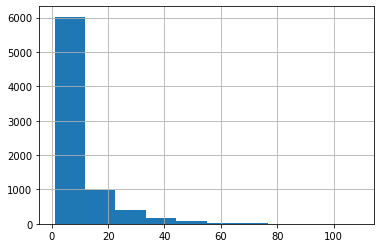

In [41]:
best_wr_seasons.loc[(best_wr_seasons.year_no==1)].play_count.hist()